# Time series model
The purpose of below code is to understand time series model.

Characteristics of time series model:
1. It is time dependent. So the basic assumption of a linear regression model that the observations are independent doesn’t hold true in this case.
2. Along with an increasing or decreasing trend, most TS have some form of seasonality trends, i.e. variations specific to a particular time frame. For example, if you see the sales of a woolen jacket over time, you will invariably find higher sales in winter seasons.

Steps to follow:
1. Check if time series is stationary with Visual test, statistical test & Augmented Dickey Fuller Test 
2. time series basic forecast:
    1. Naive approach
    2. Moving Average
    3. Simple Exponential Smoothing
    4. Holts Linear model
    5. Holts Winter model
3. Make time series stationary - 
    
    it is critical if we want the forecasting model to work well.
    
    Methods:
    
    a. Differencing: we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean
    
    b. Seasonal Differencing: In seasonal differencing, instead of calculating the difference between consecutive values, we calculate the difference between an observation and a previous observation from the same season
    
    c. Transformation: Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform; we will use log transform here
    
    6. Forecase using ARIMA

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from pandas.plotting import register_matplotlib_converters
from datetime import datetime
register_matplotlib_converters()
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 9, 6
import warnings
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

In [83]:
data = pd.read_csv('AirPassengers.csv', sep=',')
data.head()

,Month,#Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [84]:
data.shape

(144, 2)

In [93]:
# The data contains a particular month and number of passengers travelling in that month.
# But this is still not read as a TS object as the data types are ‘object’ and ‘int’.
# In order to read the data as a time series, we have to pass special arguments to the read_csv command:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m')
df = pd.read_csv('AirPassengers.csv', parse_dates = ['Month'], index_col='Month', date_parser = dateparse)
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [94]:
# check for dtype
df.dtypes

#Passengers    int64
dtype: object

In [95]:
# time-series data
ts_data = df
ts_data.head(10)

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


In [97]:
# Specify the entire range:
ts_data['1949-01-01':'1949-05-01']

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [98]:
# Use ':' if one of the indices is at ends:
ts_data[:'1949-05-01']

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


- Unlike numeric indexing, the end index is included here. 
For instance, if we index a list as a [:5] then it would return the values at indices – [0,1,2,3,4]. But here the index ‘1949-05-01’ is included in the output.

- The indices have to be sorted for ranges to work. If you randomly shuffle the index, this won’t work.

In [99]:
ts_data['1949']

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121
1949-06-01,135
1949-07-01,148
1949-08-01,148
1949-09-01,136


A TS is said to be stationary if its statistical properties such as mean, variance remain constant over time. But why is it important? Most of the TS models work on the assumption that the TS is stationary. Intuitively, we can sat that if a TS has a particular behaviour over time, there is a very high probability that it will follow the same in the future. Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

Stationarity is defined using very strict criterion. However, for practical purposes we can assume the series to be stationary if it has constant statistical properties over time, ie. the following:

1. constant mean
2. constant variance
3. an autocovariance that does not depend on time.

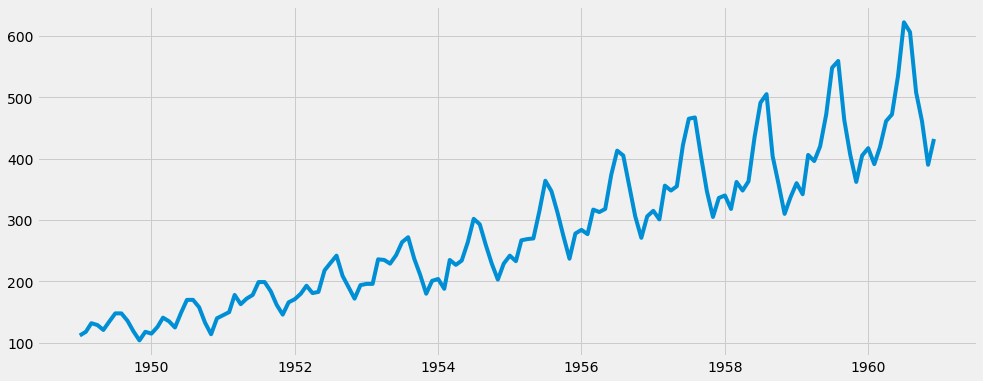

In [100]:
# In order to check if the time series is stationary: 1st plot the data and analyze visually
plt.plot(ts_data)

<b> Check if time series is stationary </b>

In [ ]:
# rolling statistics plots along with Dickey-Fuller test results
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    # Determine rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    # Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

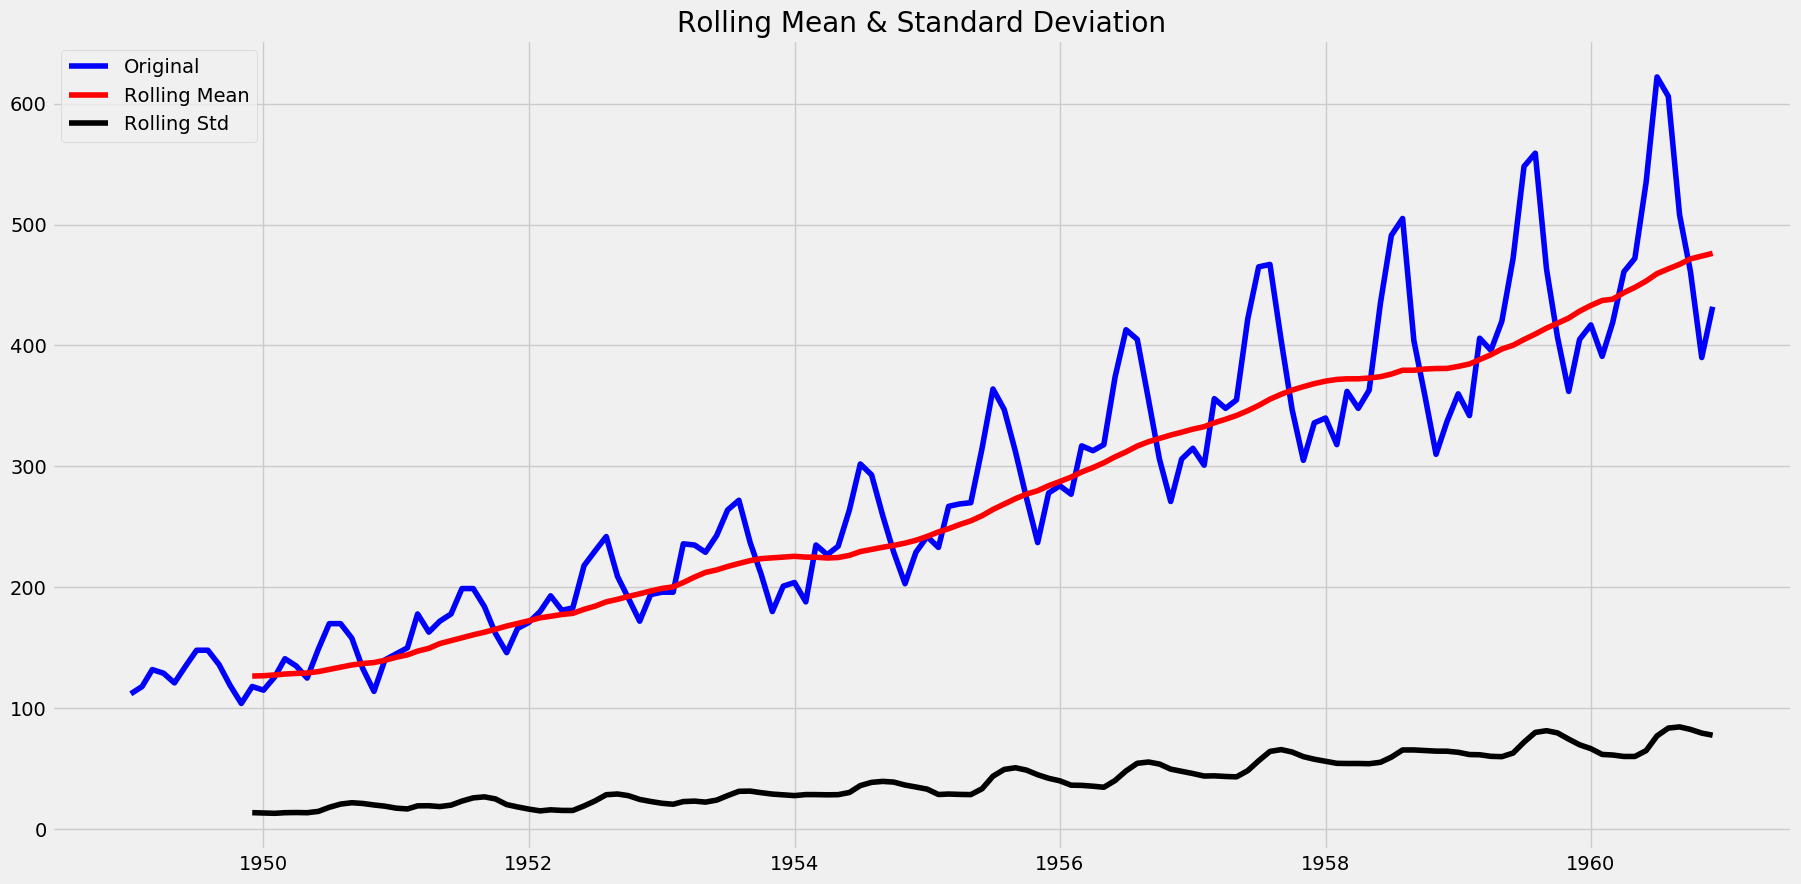

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [195]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (20,10)
test_stationarity(ts_data['#Passengers'])

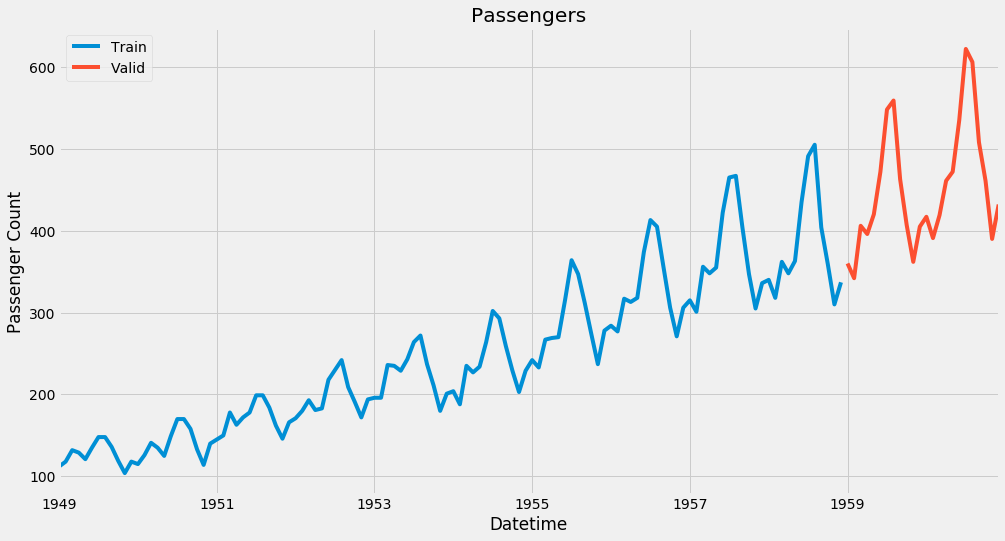

In [112]:
# divide data into training and validation sets
train = ts_data.head(120)
valid = ts_data.tail(24)

train['#Passengers'].plot(figsize = (15,8), title = 'Passengers', fontsize = 14, label = 'Train')
valid['#Passengers'].plot(figsize = (15,8), title = 'Passengers', fontsize =14, label = 'Valid')
plt.xlabel('Datetime')
plt.ylabel('Passenger Count')
plt.legend(loc = 'best')

the time series graph shows overall increasing trend in the data along with some seasonal variations

The other ways to know if the time series is stationaty or not
1. Plotting Rolling Statistics: 
    We can plot the moving average or moving variance and see if it varies with time. 
    By moving average/variance I mean that at any instant ‘t’, we’ll take the average/variance of the last year, 
    i.e. last 12 months. But again this is more of a visual technique.
    
2. Dickey-Fuller Test: 
    This is one of the statistical tests for checking stationarity. 
    Here the null hypothesis is that the TS is non-stationary. 
    The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. 
    If the ‘Test Statistic’ is less than the ‘Critical Value’, 
    we can reject the null hypothesis and say that the series is stationary.

<b>Naive Approach</b>

Text(0.5, 1.0, 'Naive Forecast')

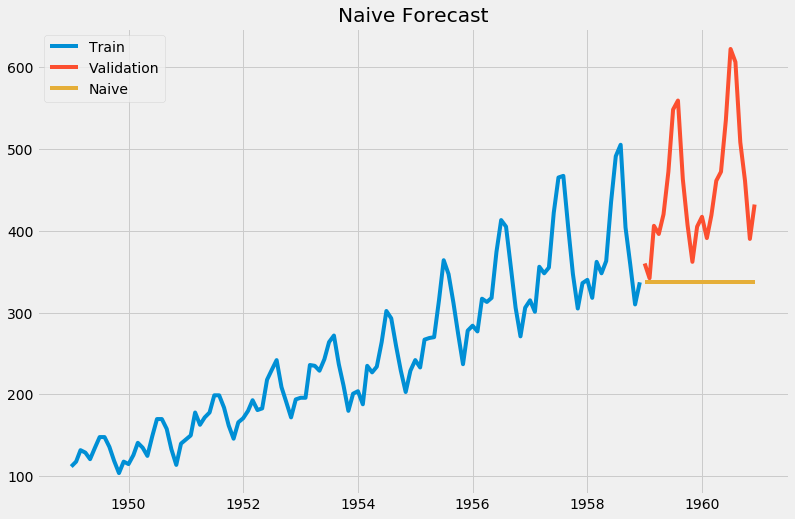

In [115]:
# check output with naive approach
dd = np.asarray(train['#Passengers'])
y_hat = valid.copy()
y_hat['naive']= dd[len(dd)- 1]
plt.figure(figsize = (12,8))
plt.plot(train.index, train['#Passengers'],label = 'Train')
plt.plot(valid.index, valid['#Passengers'], label = 'Validation')
plt.plot(y_hat.index, y_hat['naive'],  label = 'Naive')
plt.legend(loc = 'best')
plt.title('Naive Forecast')

<b>Calculate RMS Error for Naive Approach</b>

In [117]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(valid['#Passengers'], y_hat.naive))
rmse

137.32898455897794

<b> Moving Average </b>

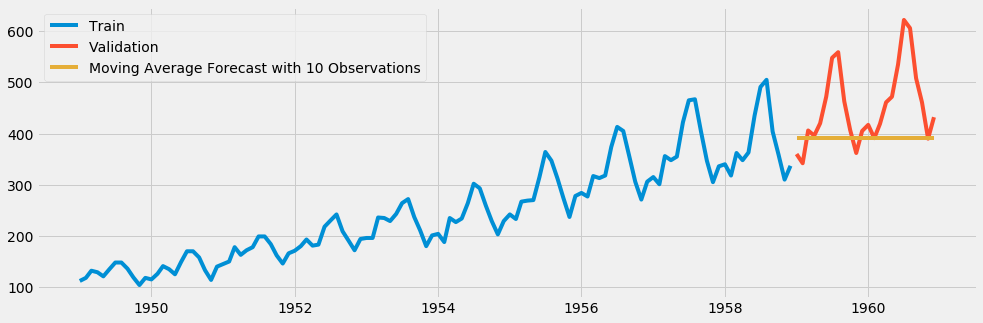

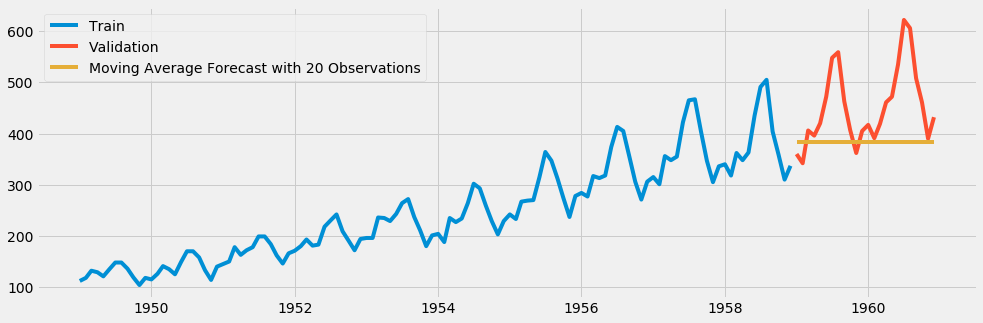

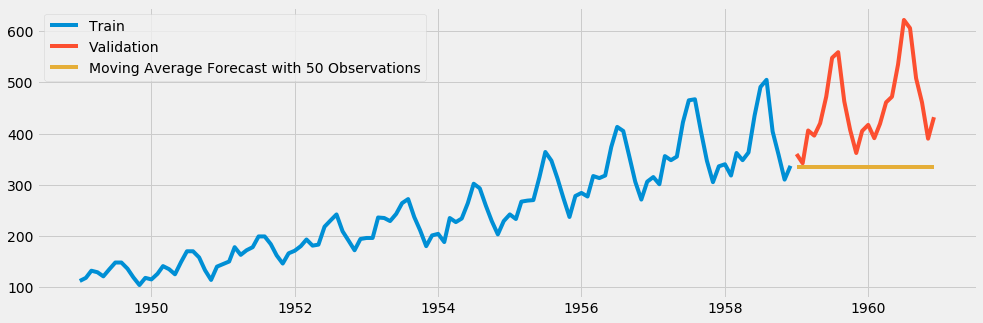

In [119]:
y_hat_avg = valid.copy()
y_hat_avg['moving_average_forecast'] = train['#Passengers'].rolling(10).mean().iloc[-1]
plt.figure(figsize = (15,5))
plt.plot(train['#Passengers'], label = 'Train')
plt.plot(valid['#Passengers'], label = 'Validation')
plt.plot(y_hat_avg['moving_average_forecast'], label = 'Moving Average Forecast with 10 Observations')
plt.legend(loc = 'best')
plt.show()

y_hat_avg = valid.copy()
y_hat_avg['moving_average_forecast'] = train['#Passengers'].rolling(20).mean().iloc[-1]
plt.figure(figsize = (15,5))
plt.plot(train['#Passengers'], label = 'Train')
plt.plot(valid['#Passengers'], label = 'Validation')
plt.plot(y_hat_avg['moving_average_forecast'],label = 'Moving Average Forecast with 20 Observations')
plt.legend(loc = 'best')
plt.show()

y_hat_avg = valid.copy()
y_hat_avg['moving_average_forecast']= train['#Passengers'].rolling(50).mean().iloc[-1]
plt.figure(figsize = (15,5))
plt.plot(train['#Passengers'], label = 'Train')
plt.plot(valid['#Passengers'], label = 'Validation')
plt.plot(y_hat_avg['moving_average_forecast'], label = "Moving Average Forecast with 50 Observations")
plt.legend(loc = 'best')
plt.show()

In [121]:
# RMSE for moving average
rmse = sqrt(mean_squared_error(valid['#Passengers'], y_hat_avg['moving_average_forecast']))
rmse

138.64077178088704

<b>Simple exponential smoothing</b>

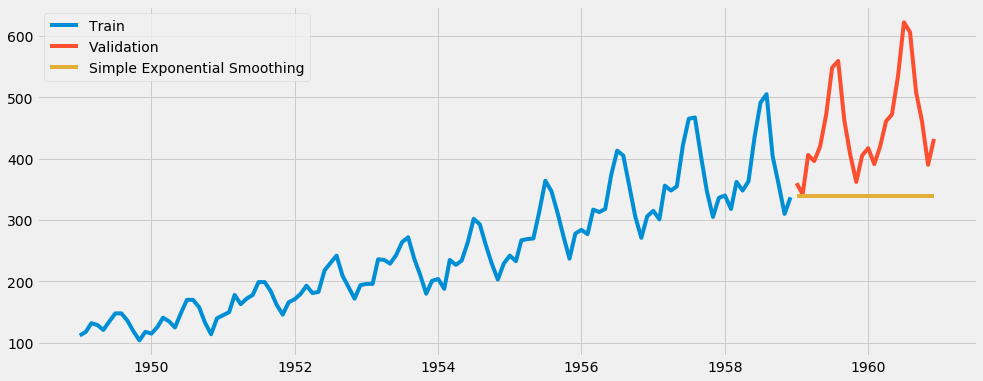

In [123]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

y_hat = valid.copy()
SE_fit = SimpleExpSmoothing(np.asarray(train['#Passengers'])).fit(smoothing_level=0.6, optimized = False)
y_hat['SimpleExpSmoothing'] = SE_fit.forecast(len(valid))
plt.figure(figsize=(15,6))
plt.plot(train['#Passengers'], label='Train')
plt.plot(valid['#Passengers'], label='Validation')
plt.plot(y_hat['SimpleExpSmoothing'], label='Simple Exponential Smoothing')
plt.legend(loc='best')
plt.show()

In [126]:
# RMSE for Simple Exponential Smoothing
rmse = sqrt(mean_squared_error(valid['#Passengers'], y_hat['SimpleExpSmoothing']))
rmse

135.6507452206376

<b>Holt's Linear Trend Model</b>

<Figure size 1500x800 with 0 Axes>

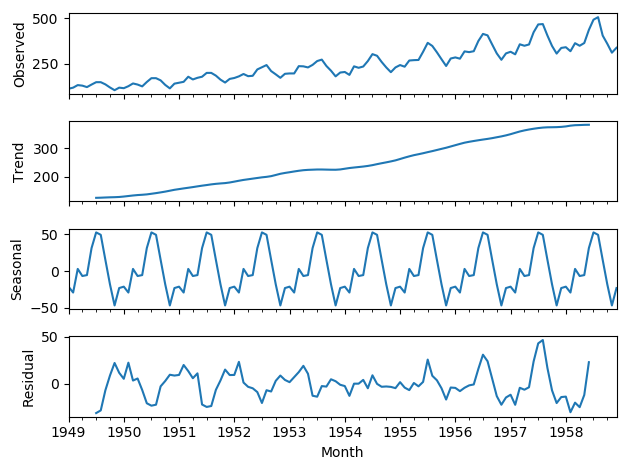

In [127]:
import statsmodels.api as sm

plt.style.use('default')
plt.figure(figsize=(15,8))
sm.tsa.seasonal_decompose(train['#Passengers']).plot()
result = sm.tsa.stattools.adfuller(train['#Passengers'])
plt.show()

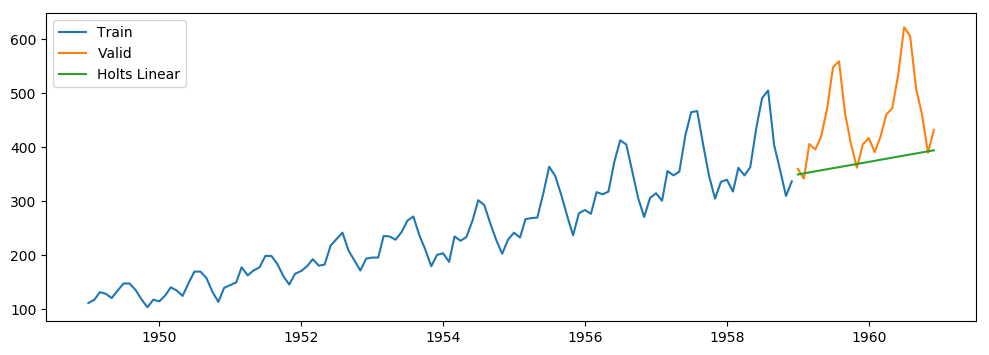

In [134]:
y_hat_holt = valid.copy()
holt_fit = Holt(np.asarray(train['#Passengers'])).fit(smoothing_level=0.5, smoothing_slope=0.001)
y_hat_holt['Holt_Linear'] = holt_fit.forecast(len(valid))
plt.style.use('default')
plt.figure(figsize=(12,4))
plt.plot(train['#Passengers'], label='Train')
plt.plot(valid['#Passengers'], label='Valid')
plt.plot(y_hat_holt['Holt_Linear'], label='Holts Linear')
plt.legend(loc='best')
plt.show()

In [136]:
# RMSE for Holts Linear model
rmse = sqrt(mean_squared_error(y_hat_holt['Holt_Linear'], valid['#Passengers']))
rmse

106.84875898383152

<b>Holts Winter model</b>

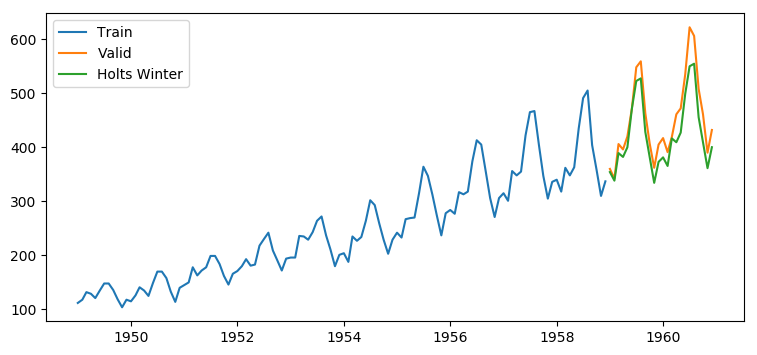

In [139]:
y_hat_avg = valid.copy()
hw_fit = ExponentialSmoothing(np.asarray(train['#Passengers']), seasonal_periods=12, trend='add', seasonal='add').fit()
y_hat_avg['Holt_Winter'] = hw_fit.forecast(len(valid))
plt.figure(figsize=(9,4))
plt.plot(train['#Passengers'], label='Train')
plt.plot(valid['#Passengers'], label='Valid')
plt.plot(y_hat_avg['Holt_Winter'], label='Holts Winter')
plt.legend(loc='best')
plt.show()

In [140]:
# RMSE for Holts winter model
rmse = sqrt(mean_squared_error(y_hat_avg['Holt_Winter'], valid['#Passengers']))
rmse

34.89744304469039

<b>ARIMA (AutoRegressive Integrated Moving Average)</b>

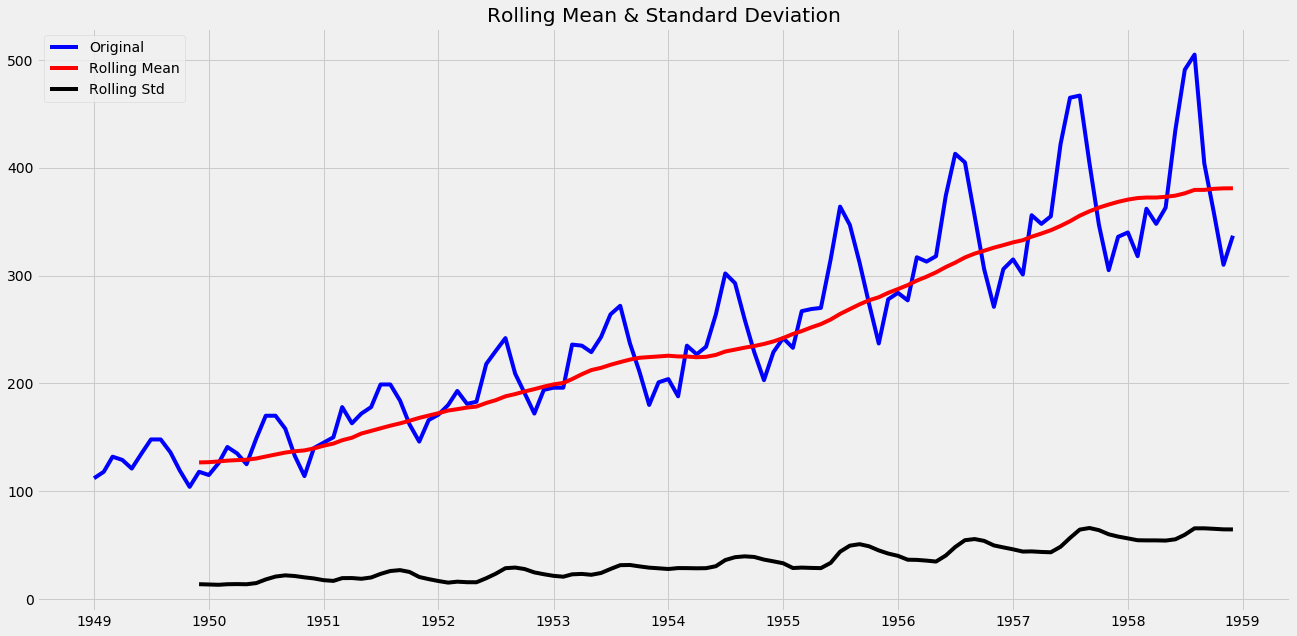

Results of Dickey-Fuller Test:
Test Statistic                  -0.773461
p-value                          0.826794
#Lags Used                      13.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

- Number of AR (Auto-Regressive) terms (p): 

AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

- Number of MA (Moving Average) terms (q): 

MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

- Number of Differences (d): 

These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

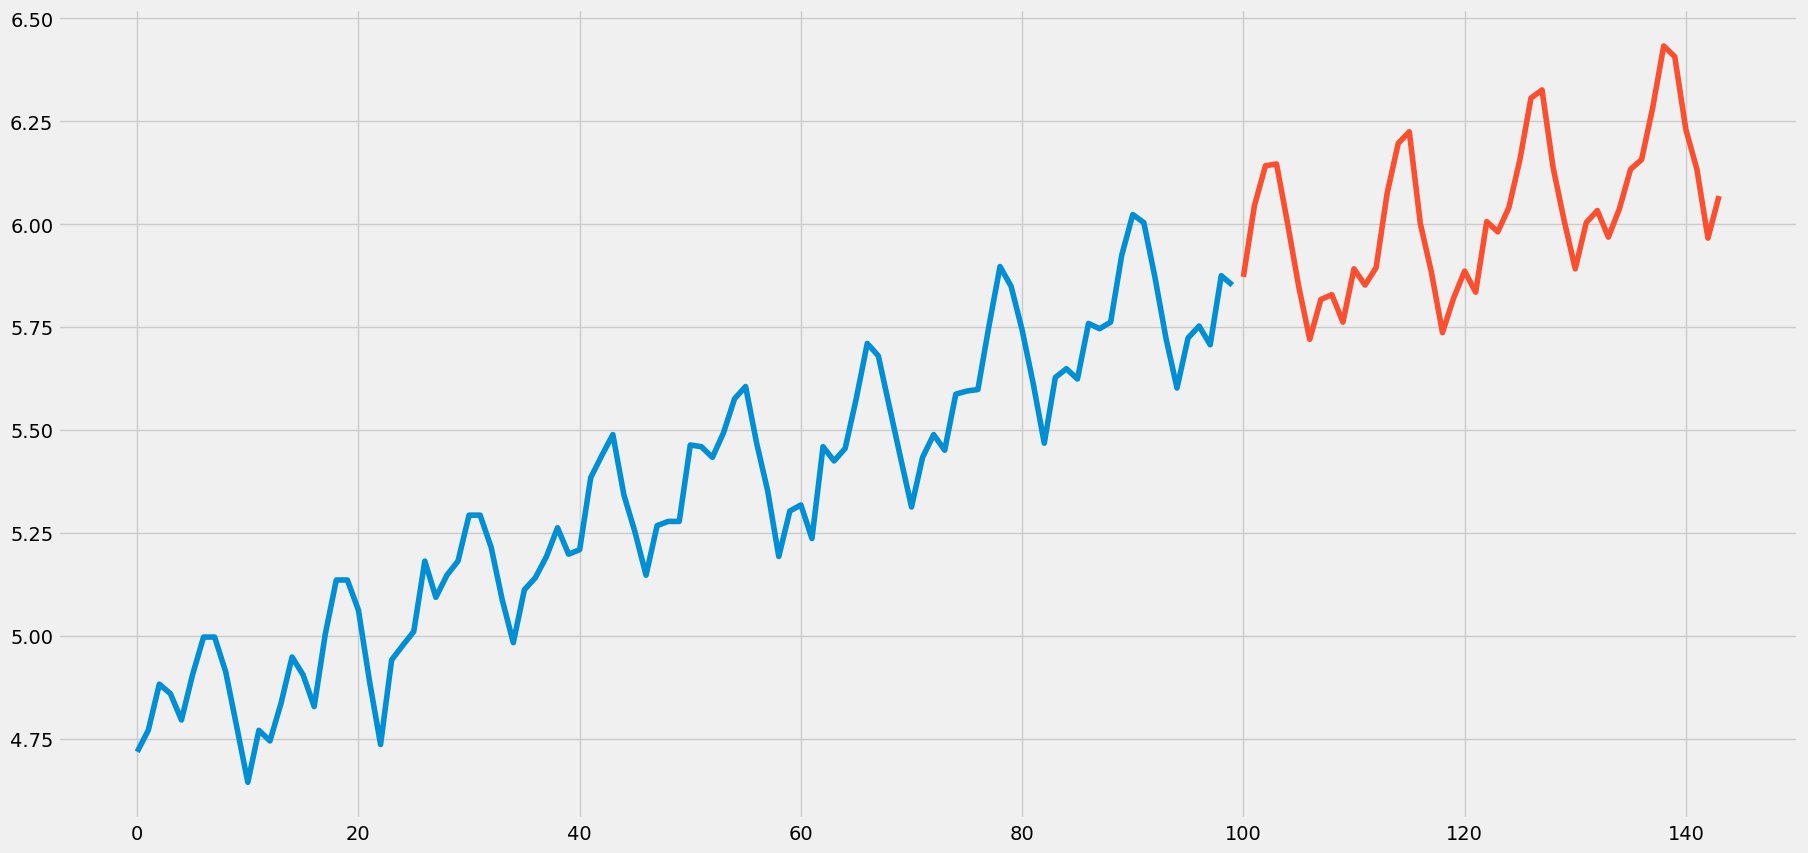

In [206]:
# Remove Trend
train_log = np.log(train['#Passengers'])
valid_log = np.log(valid['#Passengers'])

plt.plot(train_log)
plt.plot(valid_log)

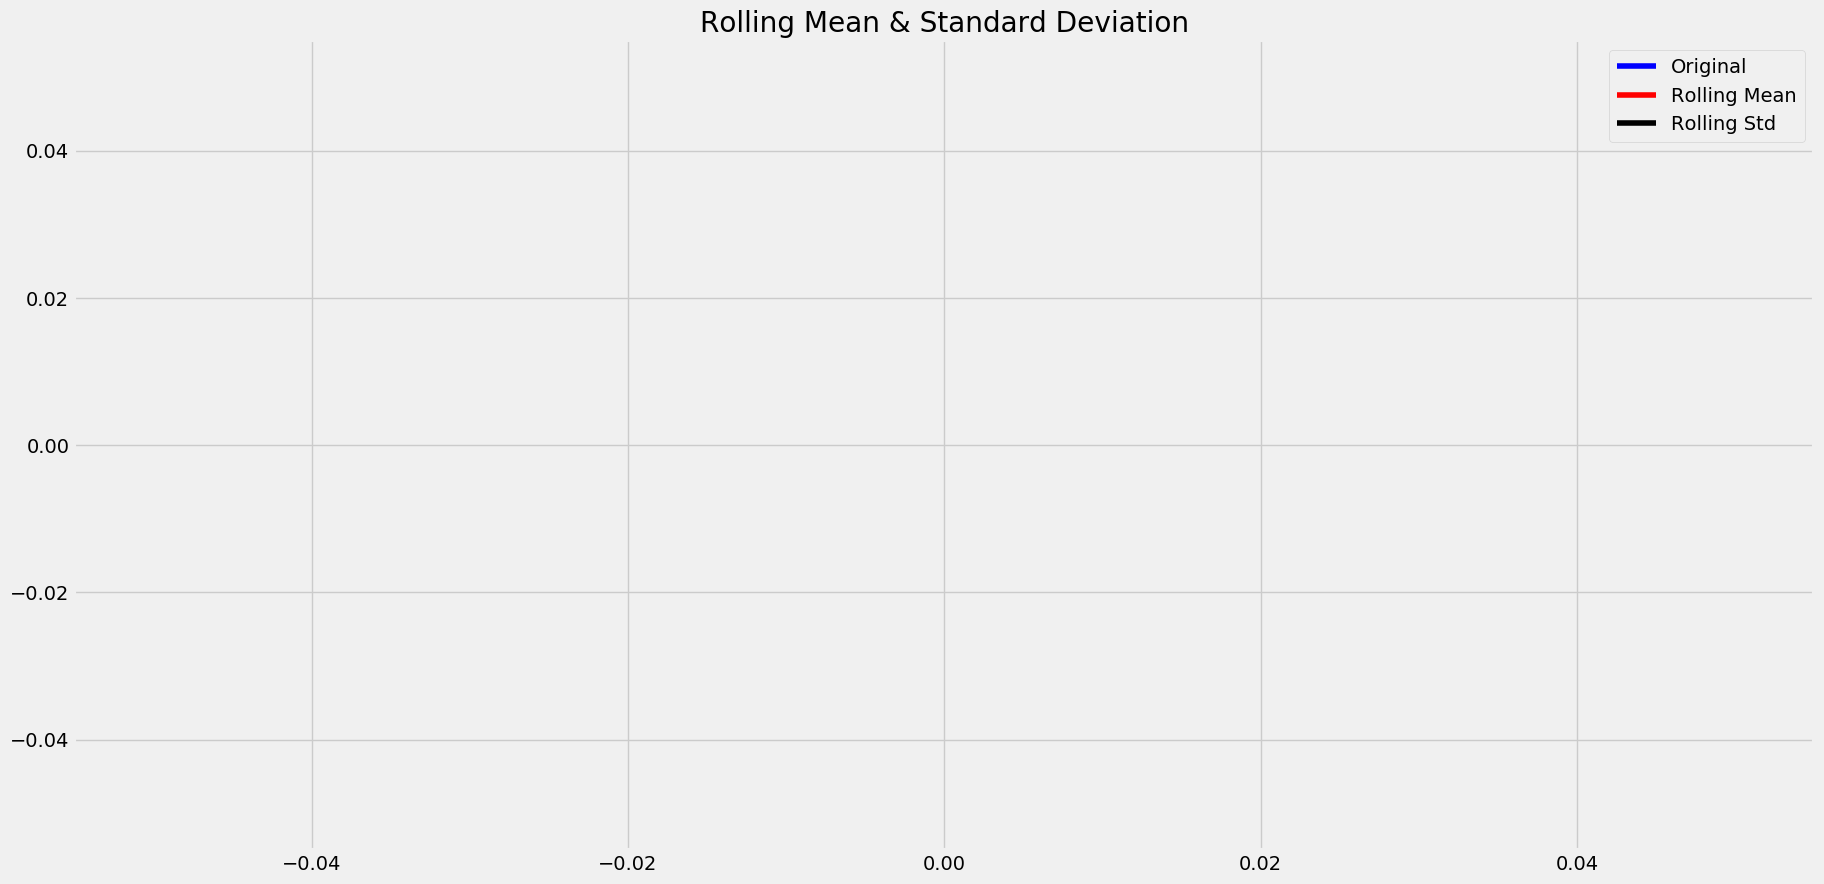

Results of Dickey-Fuller Test:


ValueError: maxlag should be < nobs

In [210]:
train_log_moving_diff = train_log - moving_avg
train_log_moving_diff.dropna(inplace = True)
test_stationarity(train_log_moving_diff)

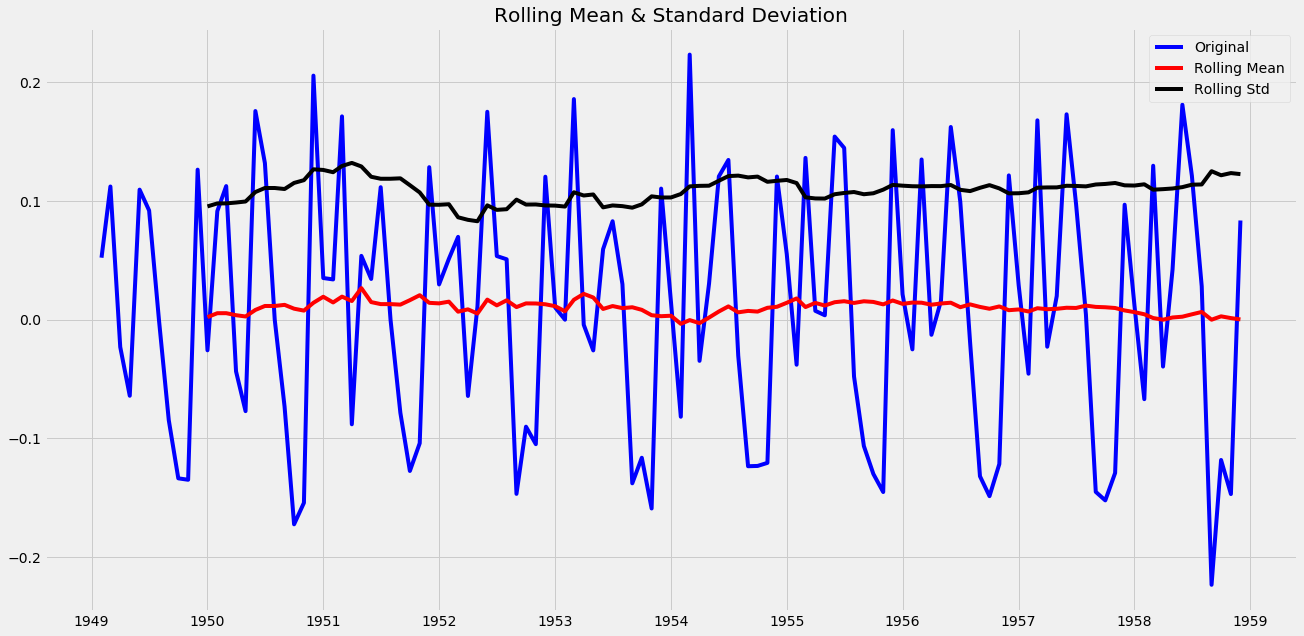

Results of Dickey-Fuller Test:
Test Statistic                  -2.343170
p-value                          0.158422
#Lags Used                      12.000000
Number of Observations Used    106.000000
Critical Value (1%)             -3.493602
Critical Value (5%)             -2.889217
Critical Value (10%)            -2.581533
dtype: float64


In [149]:
# Differncing can help to make series stable and eliminate trend
train_log_diff = train_log - train_log.shift(1)
test_stationarity(train_log_diff.dropna())

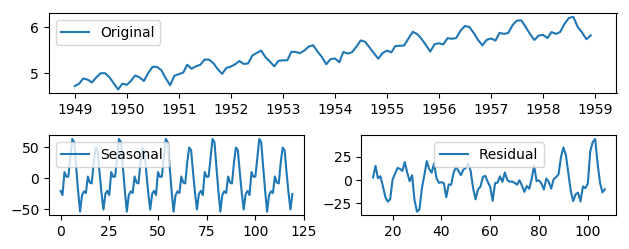

In [157]:
# Removing Seasonailty
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(pd.DataFrame(train['#Passengers']).values, freq = 24)
plt.style.use('default')
trend=decomposition.trend
seasonal=decomposition.seasonal
residual=decomposition.resid

plt.subplot(411)
plt.plot(train_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(423)
plt.plot(seasonal, label='Seasonal')
plt.legend(loc='best')

plt.subplot(424)
plt.plot(residual, label='Residual')
plt.legend(loc='best')

plt.tight_layout()

The ARIMA forecasting for a stationary time series is nothing but a linear (like a linear regression) equation. The predictors depend on the parameters (p,d,q) of the ARIMA model:

- Number of AR (Auto-Regressive) terms (p): 

AR terms are just lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

- Number of MA (Moving Average) terms (q): 

MA terms are lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value.

- Number of Differences (d): 

These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put d=0 or pass the original variable and put d=1. Both will generate same results.

In [162]:
# Autocorrelation Function (ACF) & Partial Autocorrelation Function (PACF)
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(train_log_diff.dropna(), nlags=20)
lag_pacf = pacf(train_log_diff.dropna(), nlags=20, method='ols')

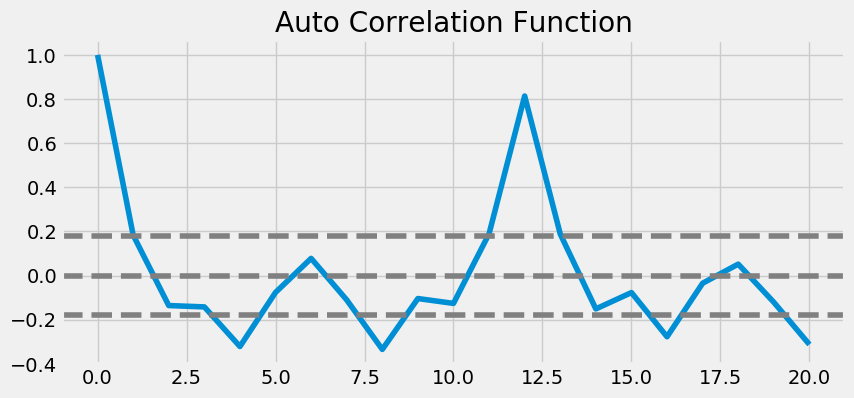

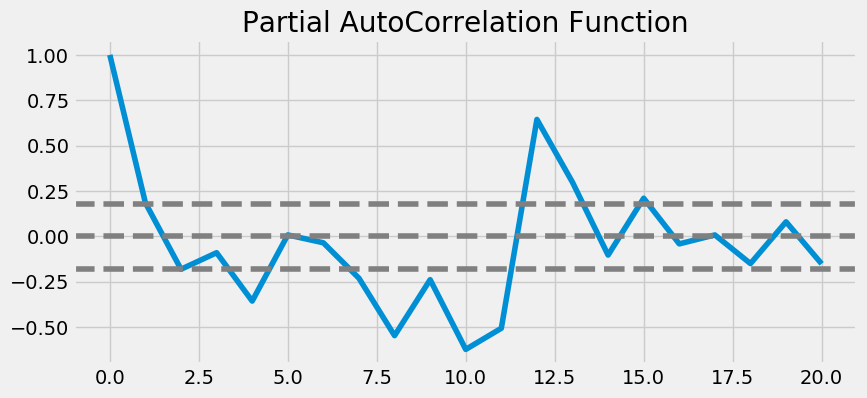

In [165]:
#ACF
plt.figure(figsize=(9,4))
#plt.style.use('fivethirtyeight')
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Auto Correlation Function')
plt.show()

#PACF
plt.figure(figsize=(9,4))
#plt.style.use('fivethirtyeight')
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train_log_diff.dropna())), linestyle='--', color='gray')
plt.title('Partial AutoCorrelation Function')
plt.show()

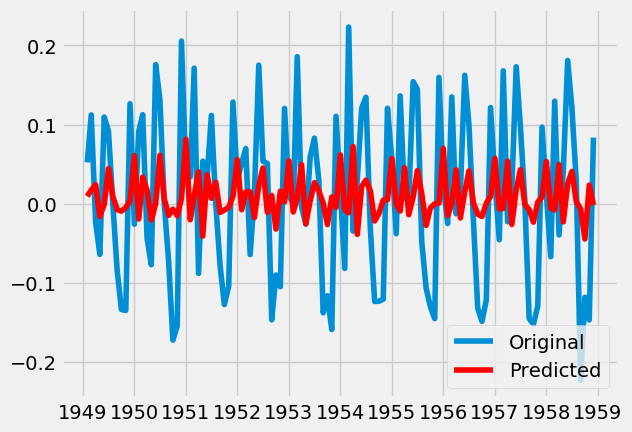

In [168]:
# AR Model
from statsmodels.tsa.arima_model import ARIMA
model = ARIMA(train_log, order=(2,1,0))
results_ar = model.fit(disp=-1)
plt.plot(train_log_diff, label='Original')
plt.plot(results_ar.fittedvalues, color='red', label='AR Predicted')
plt.legend(loc='best')

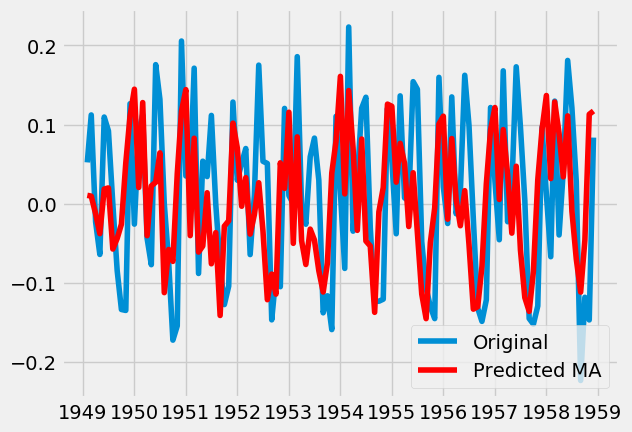

In [170]:
# MA model
model = ARIMA(train_log, order=(0,1,2))
results_ma = model.fit(disp=-1)
plt.plot(train_log_diff, label='Original')
plt.plot(results_ma.fittedvalues, color='red', label='Predicted MA')
plt.legend(loc='best')
plt.show()

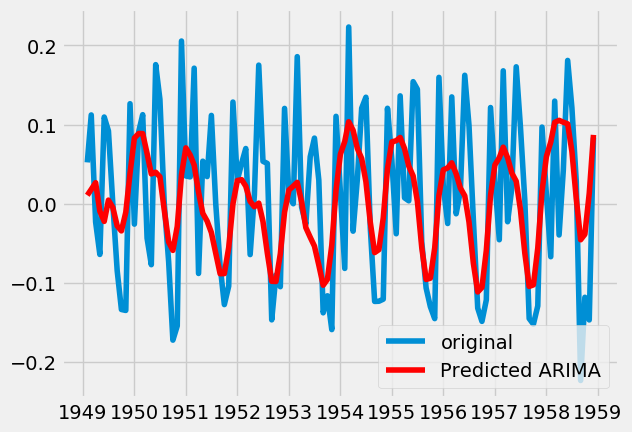

In [171]:
# combined ARIMA
model = ARIMA(train_log, order=(2,1,2))
results_arima = model.fit(disp=-1)
plt.plot(train_log_diff, label='original')
plt.plot(results_arima.fittedvalues, color='red', label='Predicted ARIMA')
plt.legend(loc='best')
plt.show()